In [1]:
from __future__ import division
import imageio as imio
import numpy as np
import scipy as sp
import scipy.fftpack as ft
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


mean:  136.9349365234375 std:  55.59281495266457 min:  1.0
shape:  (128, 128)


Text(0.5, 1.0, ' Grey Level Image (128, 128)')

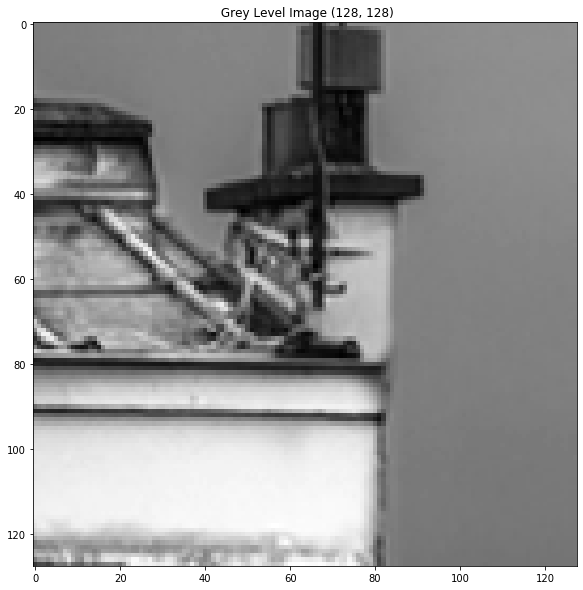

In [2]:
colored_image = imio.imread('toit.PNG')
n = 220
image = np.sum(colored_image*[0.21, 0.72 ,0.07],axis=-1)
plt.figure(figsize = (10,10))
plt.gray()
plt.imshow(image)
print("mean: ",np.mean(image),"std: ",np.std(image),"min: ",(np.min(image)))
print("shape: ",image.shape)
plt.title(" Grey Level Image " + str(np.shape(image)))


-0.0


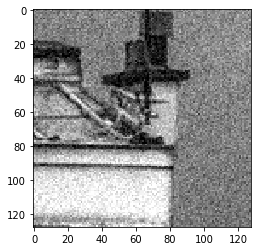

In [3]:
def snr(x, y): # signal noise ratio
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

def clamp0(x): #fixier les valeur entre 0-255
    temp =  255*(x>255) + x * (x<255) 
    return temp * (x>0)
def clamp(x,a,b): #fixier les valeur entre a-b
    temp = b*(x>b) + x * (x<b)  
    result = temp*(temp>a) + a*(x<a)
    return result
def GaussianNoise(image,sigma):
    return clamp0(image + sigma*np.random.randn(image.shape[0],image.shape[1]))

#def SaltNoise(image,sigma):
#    return clamp0(image + sigma*(np.random.randn(image.shape[0],image.shape[1])>0))

sigma = 20.0
noisy_image  = GaussianNoise(image,sigma);
print(np.min(noisy_image))
plt.imshow(noisy_image)

In [4]:
#Daubechies filter
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h) ## make sure the filter has norm 1.
print(norm(h),len(h))
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))
print("low-pass filter associated with the scaling function",h)
print("high-pass filter associated with the wavelet function",g)

0.9999999999999999 5
low-pass filter associated with the scaling function [ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]
high-pass filter associated with the wavelet function [ 0.          0.12940952  0.22414387 -0.8365163   0.48296291]


In [5]:
# Below is a circular convolution implemented. 
def cconv(x, h, d):
    if d == 1:
        return np.transpose(cconv(np.transpose(x), h, 0))
    y = np.zeros(x.shape)
    p = len(h)
    pc = int(round( float((p - 1) / 2 )))
    for i in range(0, p):
        y = y + h[i] * np.roll(x, pc-i, axis=0)
        #x = np.arange(10)
        #np.roll(x, 2)
        # >>>array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])
    return y

In [6]:
from random import random
def subsampling(x, d):
    #d dimension du sous sample
    p = 2
    if d == 0:
        y = x[::p, :]
    elif d == 1:
        y = x[:, ::p]
    return y


def upsampling(x, d):
    p = 2
    s = x.shape
    if d == 0:
        y = np.zeros((p * s[0], s[1]))
        y[::p, :] = x
    elif d == 1:
        y = np.zeros((s[0], p * s[1]))
        y[:, ::p] = x
    return y

def reverse(x):
    return x[::-1]

### Creation de la Wavelet de niveau 0 avec le filtre de daubechies

[[220.00658758 206.72084832 230.57770138 ... -15.87603551 -23.80574342
  -16.18355161]
 [287.2535265  259.64290165 246.7070093  ... -17.79069826 -15.3484372
   37.40656679]
 [246.67001872 233.86564368 284.5885191  ... -13.95034427  19.9277069
   28.10615169]
 ...
 [ 13.1240068   -4.18872631   5.80586292 ...  -8.52154598   5.74237722
   61.87647336]
 [-32.44919732  -4.23292442  38.14187825 ... -41.41077313  26.78267818
  -12.4994773 ]
 [ 48.53774764  42.19679274   6.24941496 ...  -5.53701714 -33.48806958
    4.42858338]]
64 64


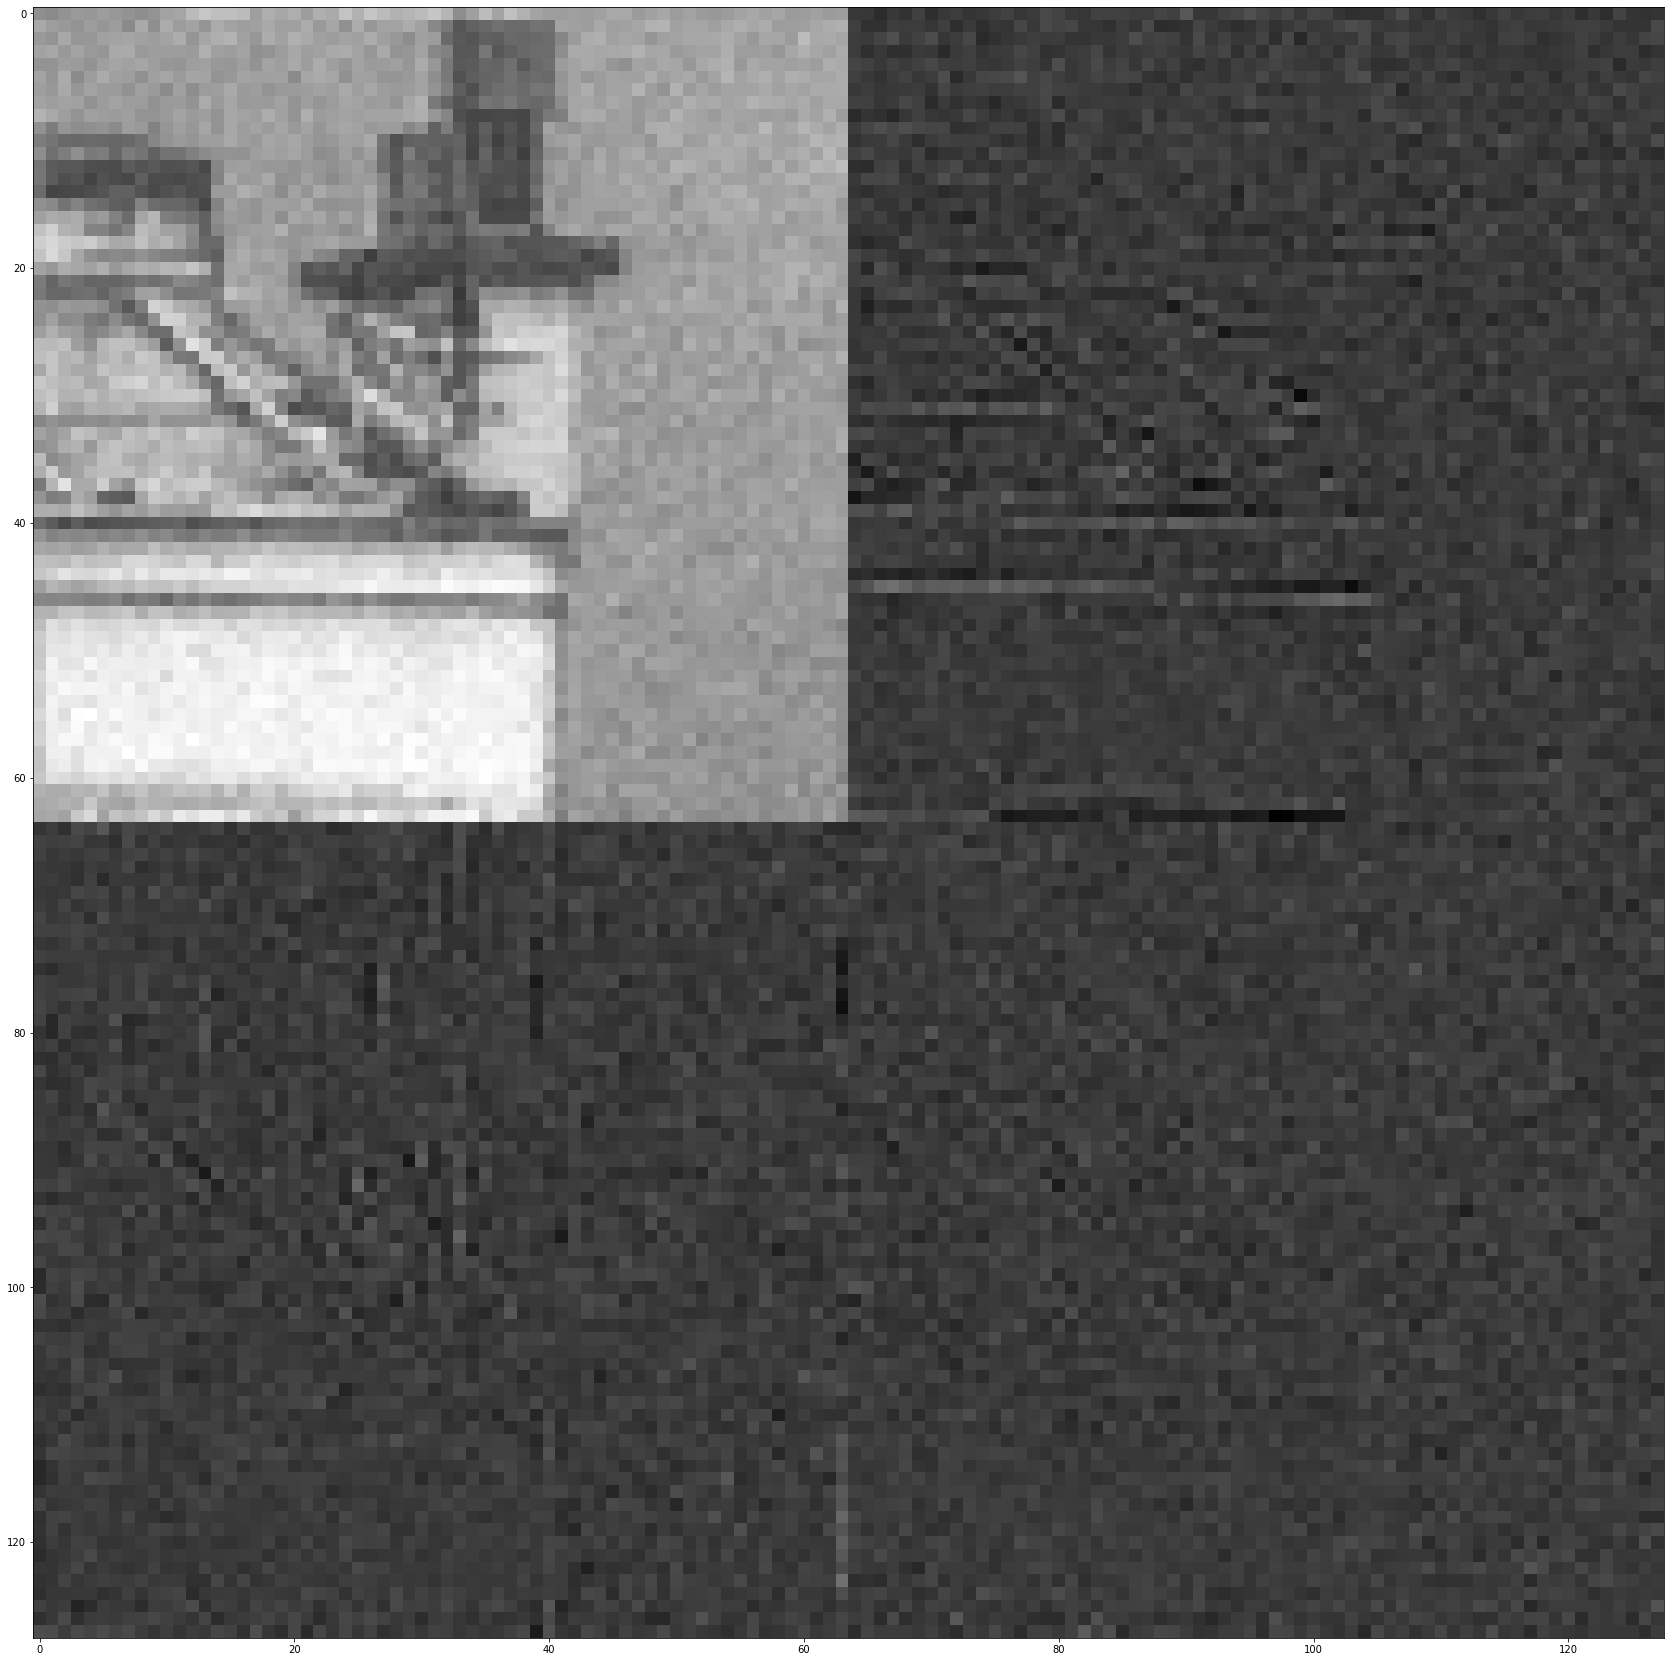

In [7]:
import math
def coarse(image,d): #p_bas
    # d is the dimension along which the operation is performed.
    # convolution of x by h along the dimension d.
    coarse= cconv(image,h,d)
    coarse = subsampling(coarse,d)
    return coarse

def fine(image,d): #p_haut
    # d is the dimension along which the operation is performed.
    # convolution of x by g along the dimension d.
    fine=cconv(image,g,d)
    fine = subsampling(fine,d)
    return fine

def W_0(image,wavelet_coeff=None):
    # start with the first dimension index 0 to get coarse and fine description along this axis
    coars_l = coarse(image,0) #p_bas ligne
    fin_l = fine(image,0)     #p_haut ligne
    # process again the previous results to get coarse and fine description along the axis of index 1.
    cc = coarse(coars_l,1)  #p_bas ligne * p_bas colone
    fc = coarse(fin_l,1)      #p_haut ligne *p_bas colone
    cf = fine(coars_l,1)      #p_bas ligne *p_haut colone
    ff = fine(fin_l,1)      #p_haut ligne *p_haut colone
     #result =[[cc,fc],[cf,ff]]
    res1 = np.concatenate([cc,fc],axis=1)
    res2= np.concatenate([cf,ff],axis=1)
    result = np.concatenate([res1,res2],axis=0)
    return result
w0 = W_0(noisy_image) # wavellet de niveau 0
print(w0)
plt.figure(figsize = (30,30))
plt.imshow(w0)

shape1= np.uint32(image.shape[0]/2)
shape2= np.uint32(image.shape[1]/2)
print(shape1,shape2)
#w1=w0[:shape1,:shape2]
#plt.figure(figsize = (30,30))
#plt.imshow(w1)
plt.show()
#print(fine(image,0),"\n",coarse(image,0))

### Determination sigma

In [49]:
def estim_sigma_W0(image,wavelet_coeff=None):
    # start with the first dimension index 0 to get coarse and fine description along this axis
    coars_l = coarse(image,0) #p_bas ligne
    fin_l = fine(image,0)     #p_haut ligne
    # process again the previous results to get coarse and fine description along the axis of index 1.
    cc = coarse(coars_l,1)  #p_bas ligne * p_bas colone
    fc = coarse(fin_l,1)      #p_haut ligne *p_bas colone
    cf = fine(coars_l,1)      #p_bas ligne *p_haut colone
    ff = fine(fin_l,1)      #p_haut ligne *p_haut colone
    result = np.median(np.abs(fc)) + np.median(np.abs(cf)) + np.median(np.abs(ff))
    result = (result/3)/0.6745
    return result
sigma_w0_estim = estim_sigma_W0(noisy_image) # wavellet de niveau 0
print("sigma estimée= ",sigma_w0_estim)
print("erreur= ",((np.abs(sigma_w0_estim-sigma))/sigma)*100,"%")
### L'estimation de sigma ce fait uniquement sur l'ondelette de niveaux j-1
#def estim_sigma_all(image,iterations =1):
#    shape1= np.uint32(image.shape[0]/2)
#    shape2= np.uint32(image.shape[1]/2)
#    #print(shape1,shape2)
#    #plt.imshow(image[shape1,shape2])
#    wavelet_transform = W_0(image)
#    ## iterate the 1step wavelet transform implemented above.
#    it = iterations
#    estim_sigma = estim_sigma_W0(noisy_image) ;
#    
#    while it>0 and shape1%2==0 and shape2%2==0 and shape1>1 and shape2>1:
#        # on test le nombre d'itération ainsi que la taille de l'image d'entrée
#        wit = W_0(wavelet_transform[:shape1,:shape2])
#        print(estim_sigma)
#        estim_sigma = (estim_sigma + estim_sigma_W0(wavelet_transform[:shape1,:shape2])) 
#        estim_sigma = estim_sigma/2;
#        
#        wavelet_transform[:shape1,:shape2] = wit
#        shape1=np.uint32(shape1/2)
#        shape2=np.uint32(shape2/2)
#        it=it-1
       # print(it)
#    return estim_sigma
#nwav = 2;
#sigma_wnwav_estim= estim_sigma_all(noisy_image,nwav)    
#print(sigma_wnwav_estim)

sigma estimée=  21.099685109640284
erreur=  5.498425548201418


### Wavelet transform sur N niveaux

64 64
1
0


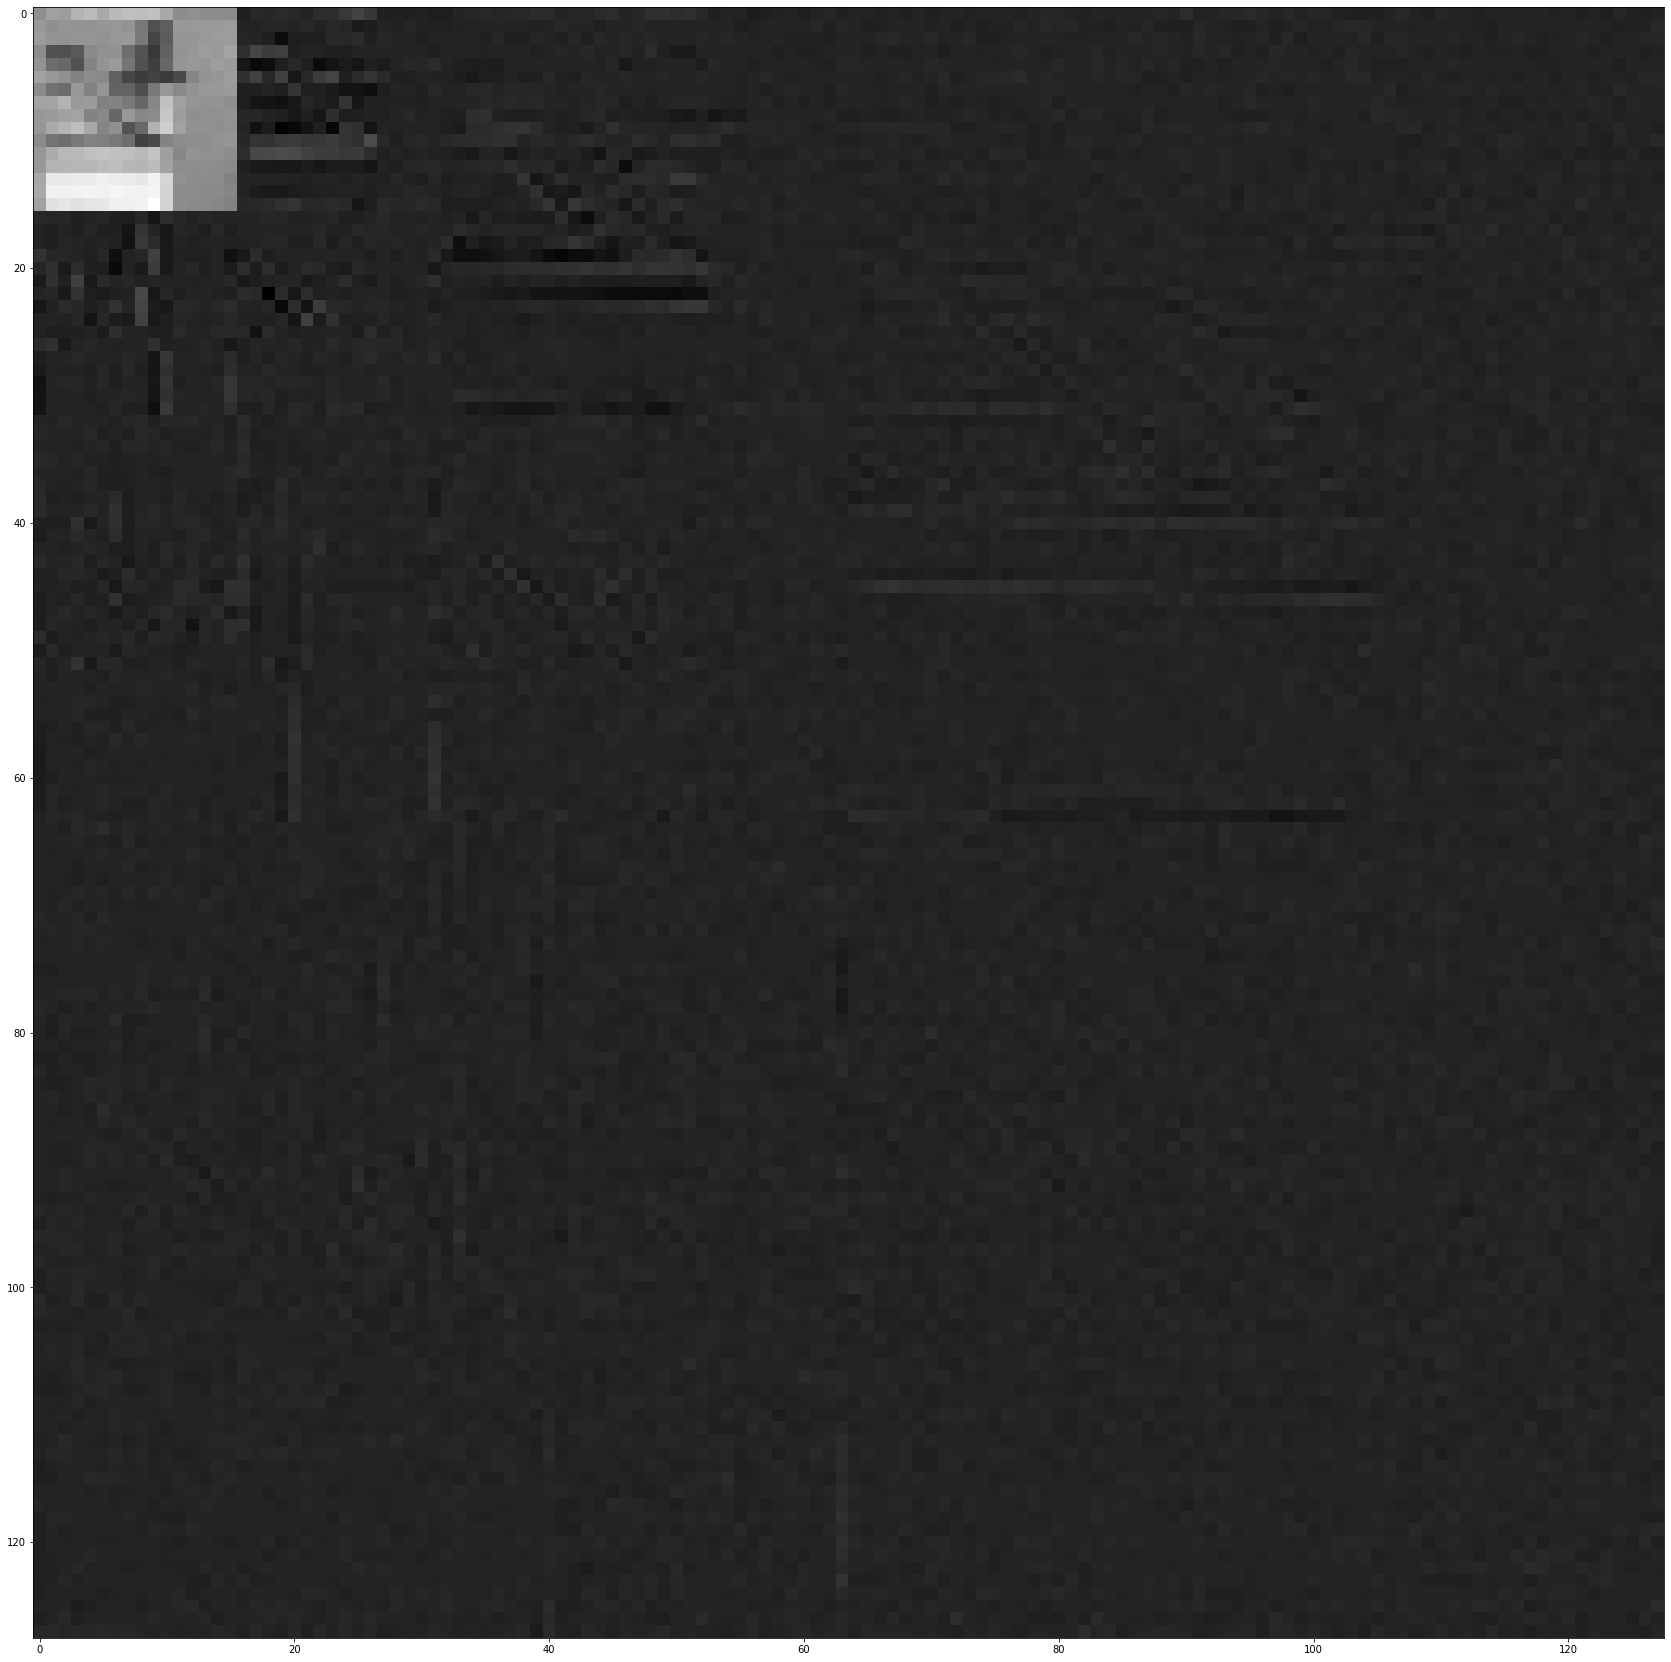

In [8]:
def WaveletTransform(image,iterations =1):
    shape1= np.uint32(image.shape[0]/2)
    shape2= np.uint32(image.shape[1]/2)
    print(shape1,shape2)
    #plt.imshow(image[shape1,shape2])
    wavelet_transform = W_0(image)
    ## iterate the 1step wavelet transform implemented above.
    it = iterations
    while it>0 and shape1%2==0 and shape2%2==0 and shape1>1 and shape2>1:
        # on test le nombre d'itération ainsi que la taille de l'image d'entrée
        wit = W_0(wavelet_transform[:shape1,:shape2])
        wavelet_transform[:shape1,:shape2] = wit
        shape1=np.uint32(shape1/2)
        shape2=np.uint32(shape2/2)
        it=it-1
        print(it)
    return wavelet_transform
nwav = 2;
w1=WaveletTransform(noisy_image,nwav) # nwav=2 -> niveau 0 1 2 nwav=3 -> niveau 0 1 2 3
plt.figure(figsize = (30,30))
plt.imshow(w1)
plt.show()

### Meilleur visualisation de la transformée

In [9]:
def rescale(f,a=0,b=1):
    ## function that rescale f between a and b.
    rang = f.max() - f.min()
    g = (f - f.min()).copy()
    if rang > 0:
        g = g / rang
    return a + g*(b-a)

def rescaleWav(A):
    ## function dedicated to a proper rescale of wavelet representation (particular case of the previous one).
    sup = abs(A).max()
    B = A.copy()
    if sup > 0:
        B = .5 + .5 * A / sup
    return B
    
def PlotWavelet(wavelet, iterations=1):
    ## Plot the wavelet representation, need to specify the number of iterations (or scales at which the FWT is computed).
    n = wavelet.shape[1]
    Jmax = int(np.log2(n)) - 1
    Jmin = Jmax - iterations + 1
    
    U = wavelet.copy()
    for j in np.arange(Jmax, Jmin - 1, -1):
        U[:2 ** j:,    2 ** j:2 **
            (j + 1):] = rescaleWav(U[:2 ** j:, 2 ** j:2 ** (j + 1):])
        U[2 ** j:2 ** (j + 1):, :2 **
          j:] = rescaleWav(U[2 ** j:2 ** (j + 1):, :2 ** j:])
        U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):] = (
            rescaleWav(U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):]))
    # coarse scale
    U[:2 ** j:, :2 ** j:] = rescale(U[:2 ** j:, :2 ** j:])
    # plot underlying image
    plt.imshow(U)
    # display crosses
    for j in np.arange(Jmax, Jmin - 1, -1):
        plt.plot([0, 2 ** (j + 1)], [2 ** j, 2 ** j], 'b')
        plt.plot([2 ** j, 2 ** j], [0, 2 ** (j + 1)], 'b')
    return U

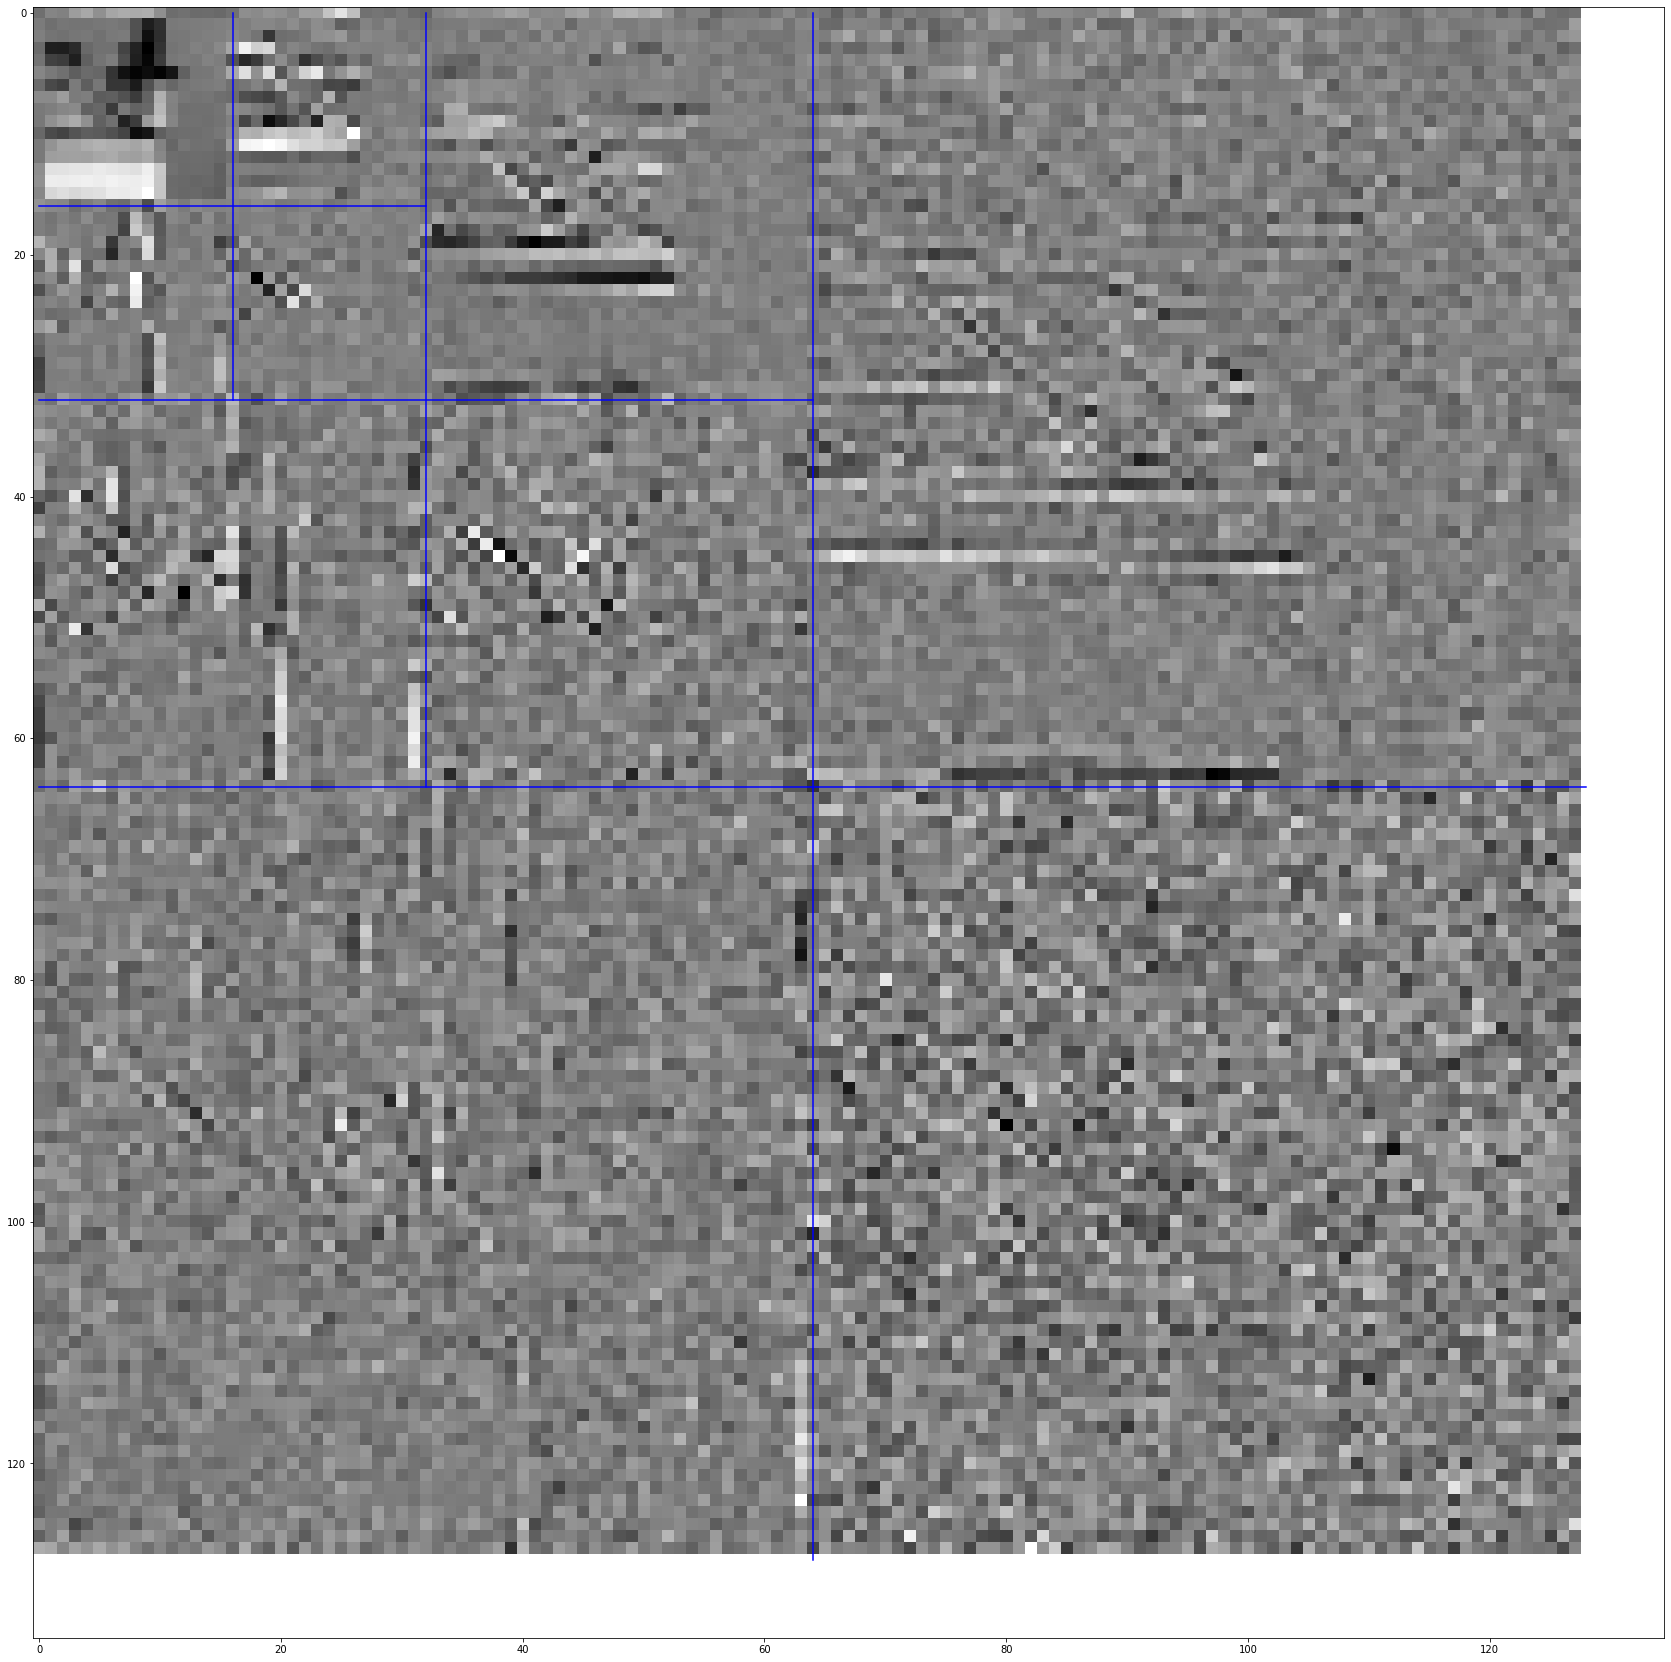

In [10]:
plt.figure(figsize = (30,30))
#w0=rescale(w0)
PlotWavelet(w1,nwav+1)
plt.show()

### Hard Thresholding

In [11]:
def Hardthreeshold(wavelet,thresh):
    #wavelet = clamp0(wavelet)
    #shape1= np.uint32(image.shape[0])
    #shape2= np.uint32(image.shape[1])
    #print(shape2,shape1)
    return np.where(abs(wavelet) > thresh, wavelet, 0) 
def SoftThreshold(wavelet,thresh):
    hardthresh = Hardthreeshold(wavelet,thresh)
    shape1= np.uint32(hardthresh.shape[0])
    shape2= np.uint32(hardthresh.shape[1])
    return np.where(hardthresh !=0, hardthresh - np.ones(shape1,shape2)*thresh*np.sign(hardthresh), hardthresh )
    

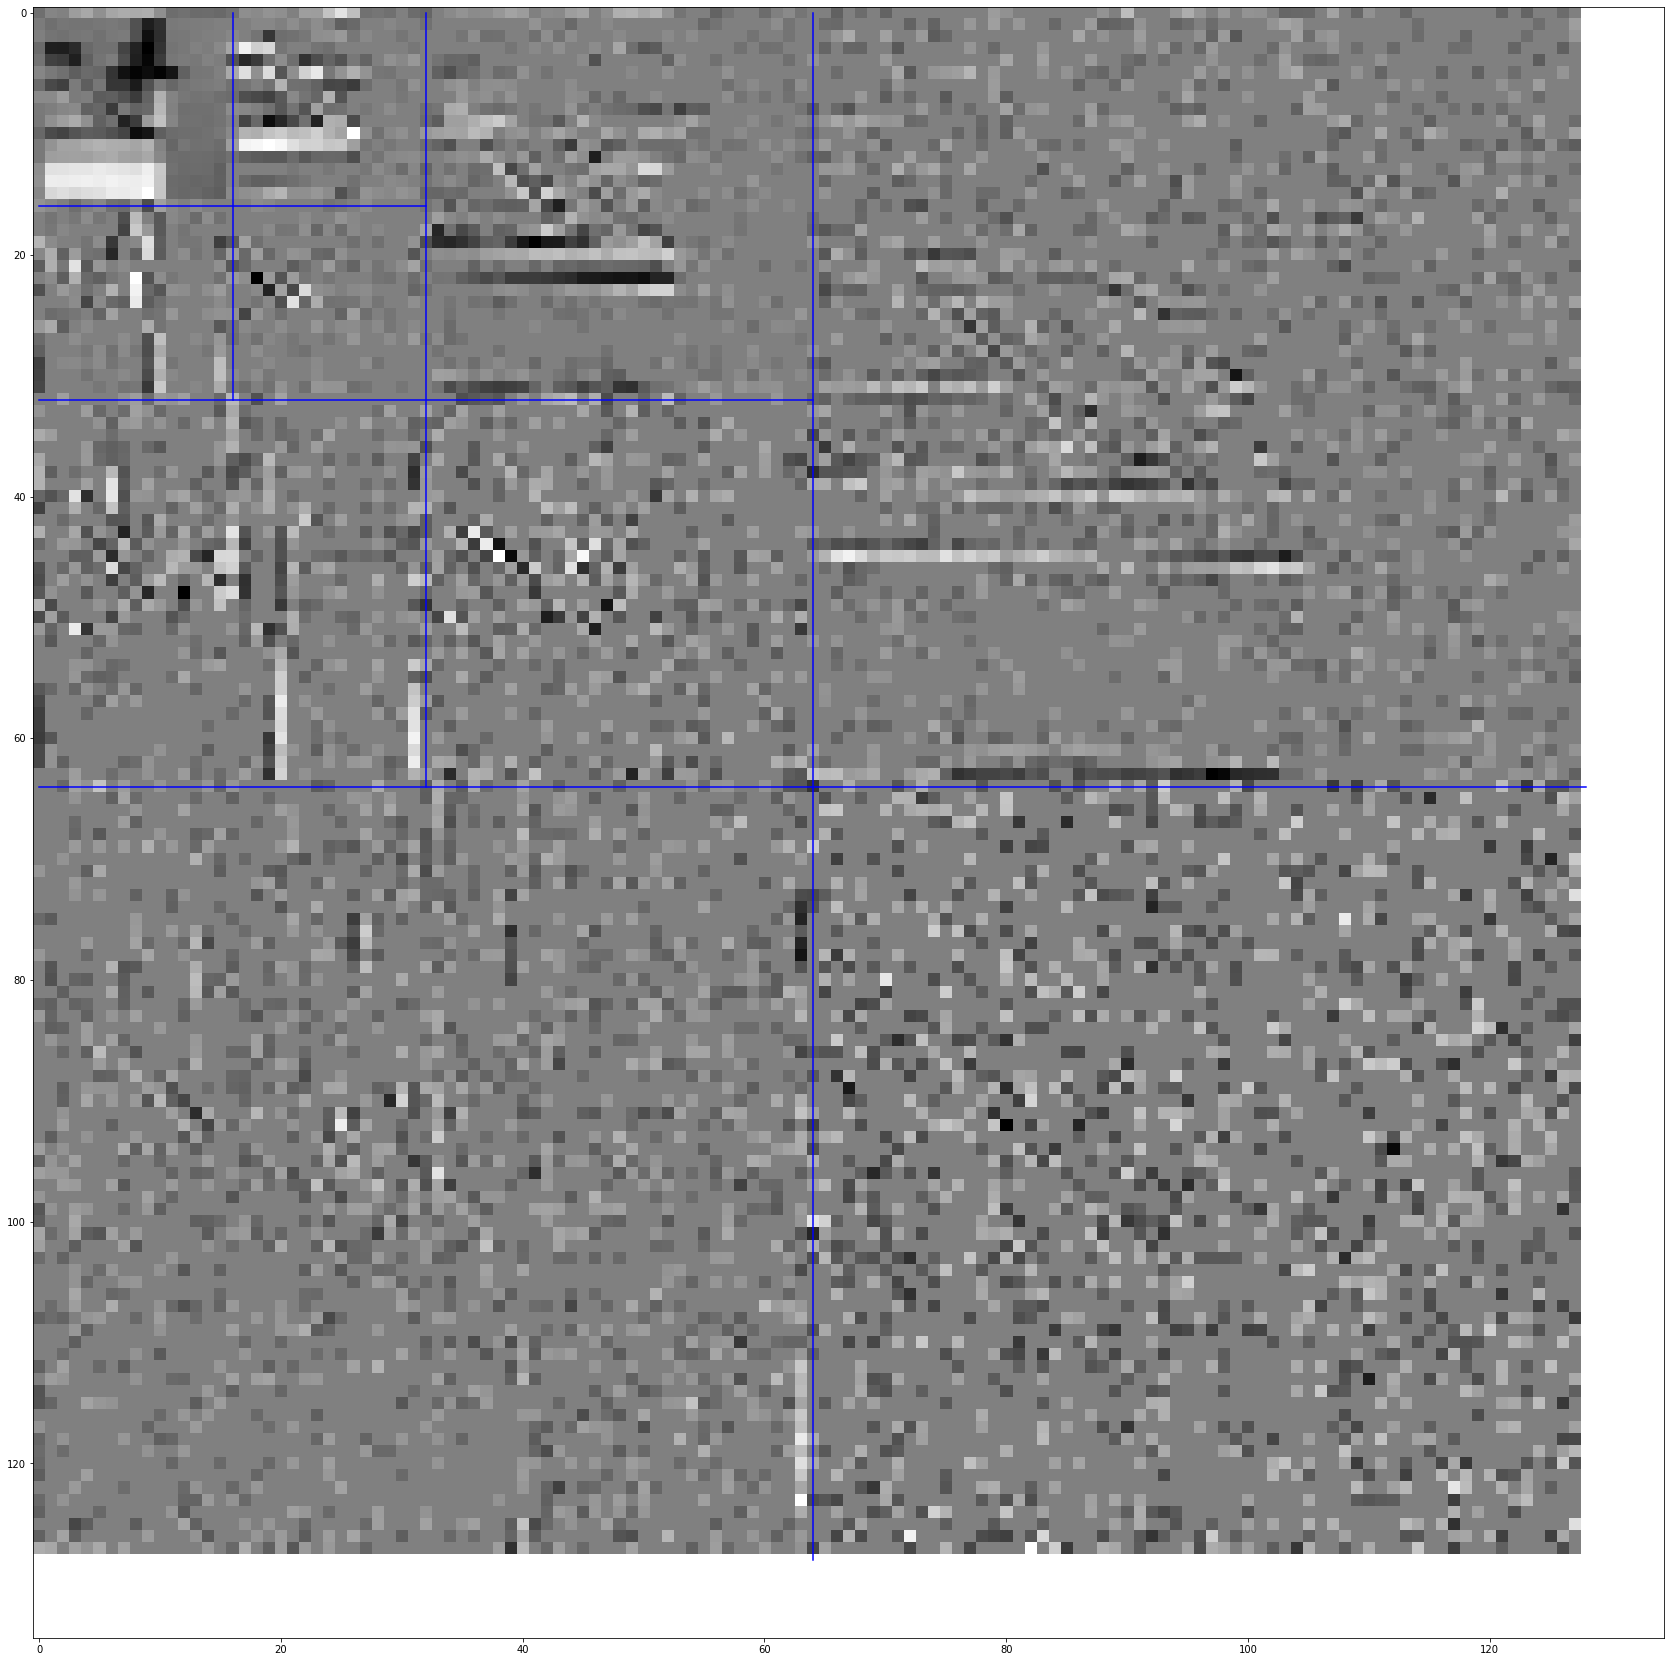

Min W1:  -338.3104671153941  Max W1:  2056.354122578647  threeshold : 20.563541225786473 Mean w1 with Hard threeshold:  16.830499807961754


In [12]:
hardT = np.max(w1)*0.01;   
w1hardT = Hardthreeshold(w1,hardT)
#print(np.sign(w1hardT) )
shape1= np.uint32(w1hardT.shape[0])
shape2= np.uint32(w1hardT.shape[1])
#print(np.where(np.ones(shape1,shape2)*hardT*np.sign(w1hardT) < 0 ))
plt.figure(figsize = (30,30))
PlotWavelet(w1hardT,nwav+1)
plt.show()
print("Min W1: ", np.min(w1)," Max W1: " ,np.max(w1)," threeshold :",hardT,"Mean w1 with Hard threeshold: ",np.mean(w1hardT))

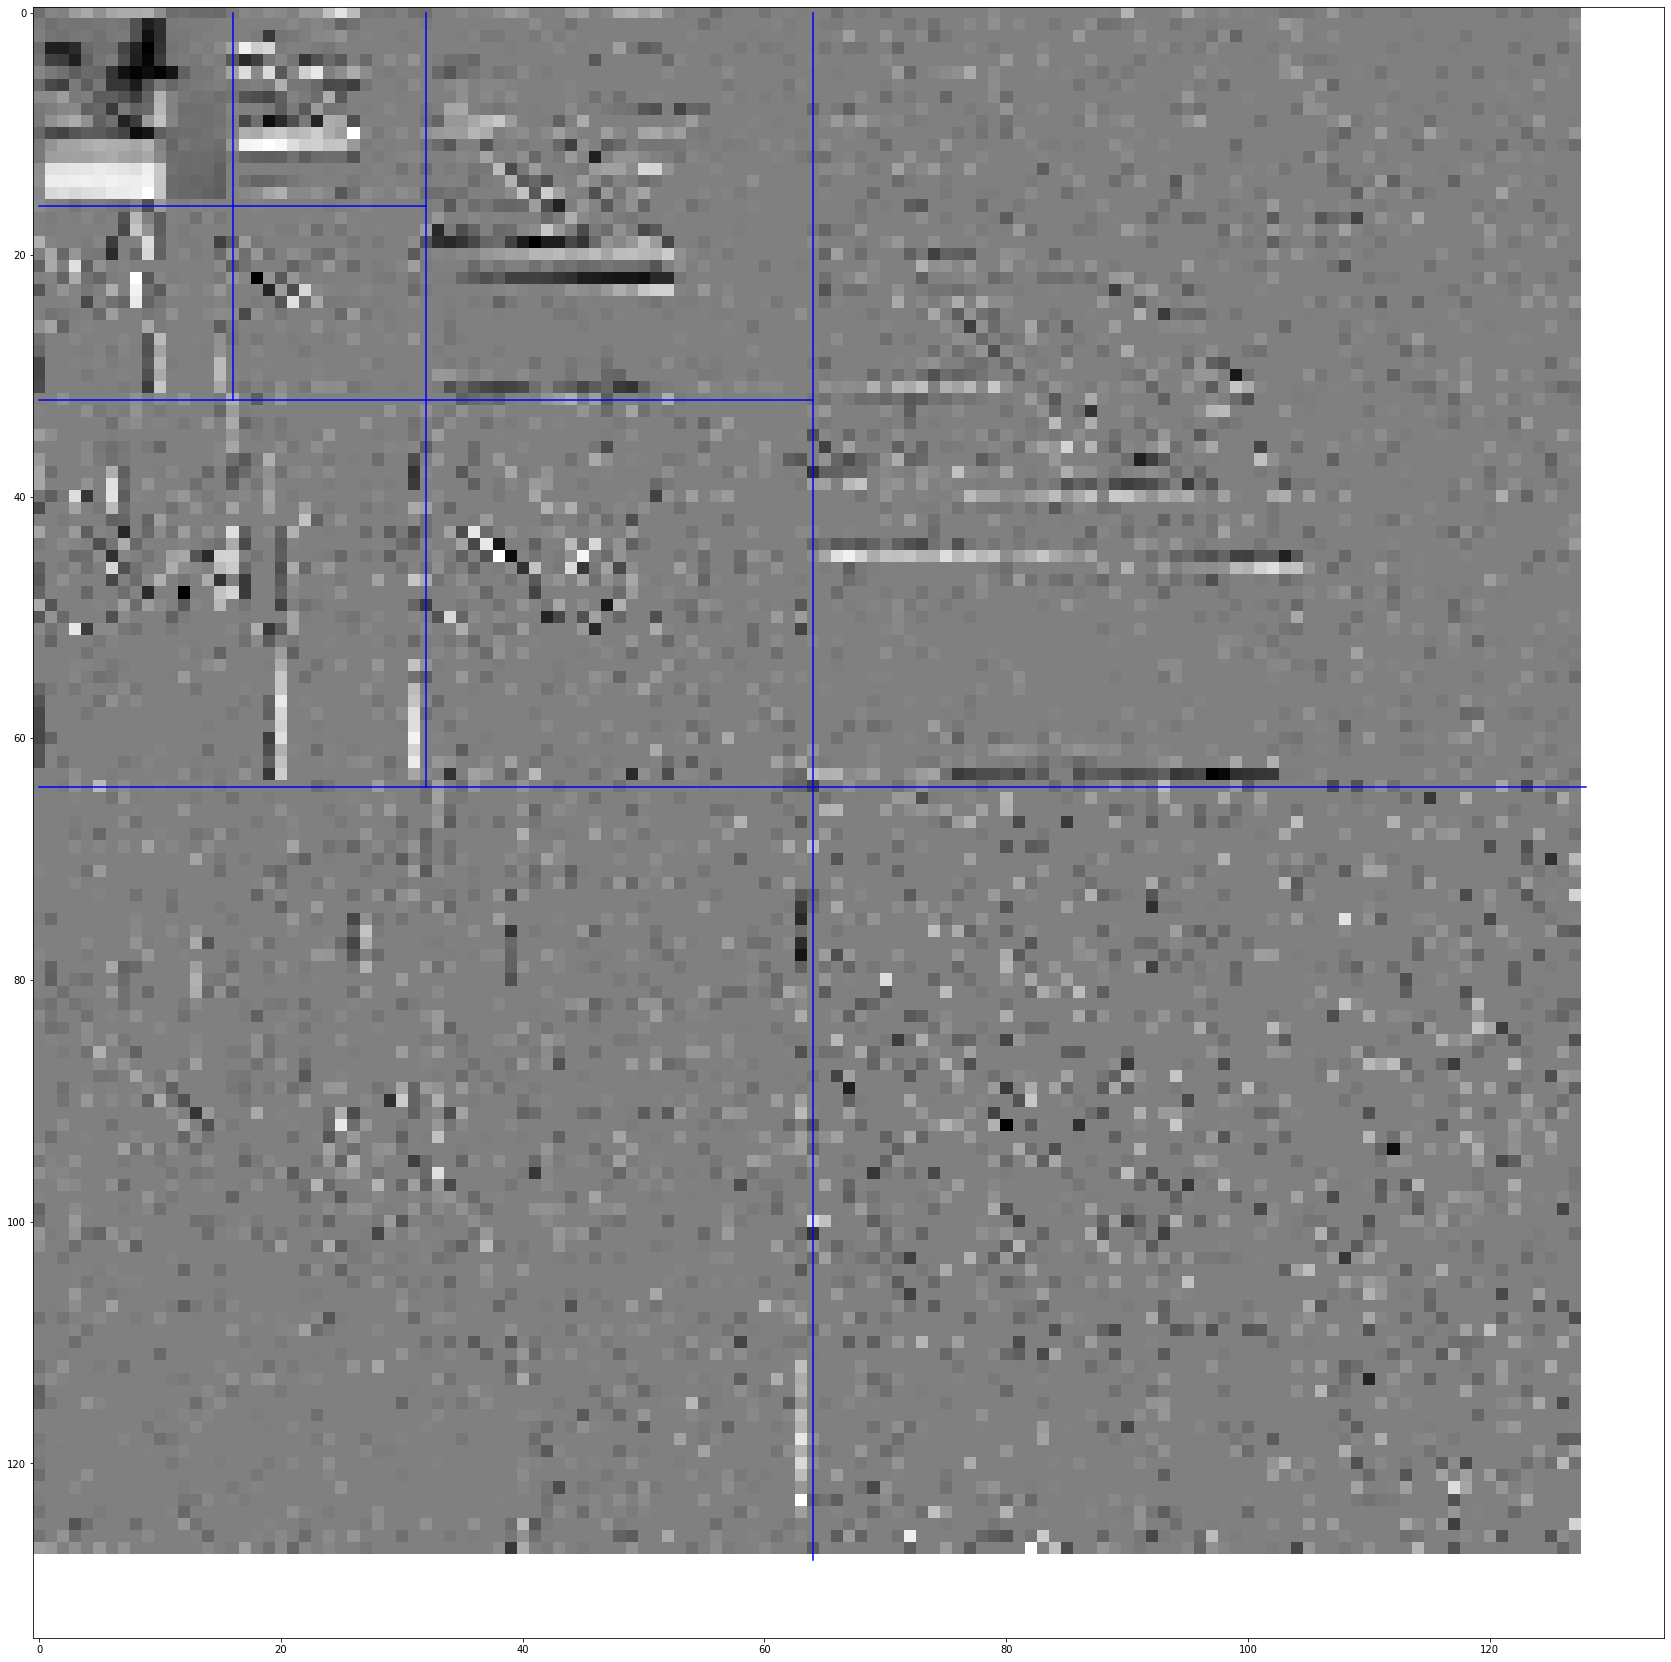

Min W1:  -338.3104671153941  Max W1:  2056.354122578647  threeshold :  20.563541225786473  Mean w1 with Soft threeshold:  16.74013268343438


In [13]:
plt.figure(figsize = (30,30))
w1soft= SoftThreshold(w1,hardT)
PlotWavelet(w1soft,nwav+1)
plt.show()
print("Min W1: ", np.min(w1)," Max W1: " ,np.max(w1)," threeshold : ",hardT," Mean w1 with Soft threeshold: ",np.mean(w1soft))



### Operateur inverse

In [14]:
def AdjointCoarse(image,d):
    adjoint_h = reverse(h)
    return cconv(upsampling(image,d),adjoint_h,d)
def AdjointFine(image,d):
    adjoint_g = reverse(g)
    return cconv(upsampling(image,d),adjoint_g,d)


### Reconstruction niveau W0

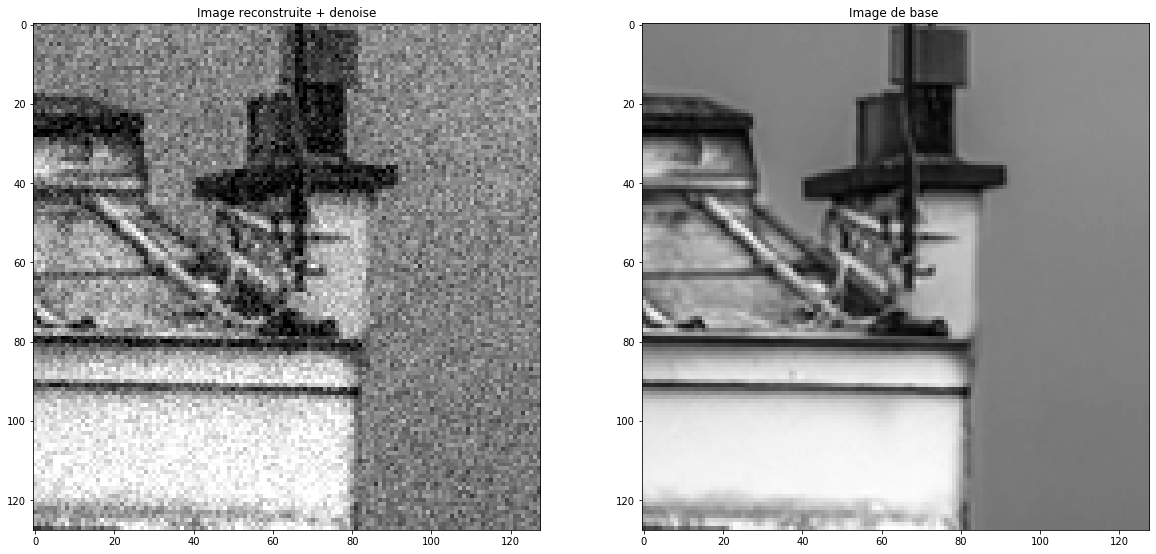

In [15]:
# inverse of a one-step wavelet transform.
def IW_0(wavelet,affiche=0):

    n = np.shape(wavelet)[0]//2 # taille  d'une des quatre parties d'une wavelet
    temp_cc = wavelet[0:n,0:n]
    temp_fc = wavelet[0:n,n:]
    temp_cf = wavelet[n:,0:n]
    temp_ff = wavelet[n:,n:]
    if affiche==1:
        plt.figure(figsize = (20,20))
        plt.subplot(2,2,1)
        plt.imshow(temp_cc)
        plt.subplot(2,2,2)
        plt.imshow(temp_cf)
        plt.subplot(2,2,3)
        plt.imshow(temp_fc)
        plt.subplot(2,2,4)
        plt.imshow(temp_ff)

    adjcoarse1_0 = AdjointCoarse(temp_cc,1)
    adjcoarse1_1 = AdjointCoarse(adjcoarse1_0,0)
    
    adjcoarse2_0 = AdjointCoarse(temp_fc,1)
    adjfine2_1 = AdjointFine(adjcoarse2_0,0)
    
    adjfine3_0 = AdjointFine(temp_cf,1)
    adjcoarse3_1 = AdjointCoarse(adjfine3_0,0)
    
    adjfine4_0 = AdjointFine(temp_ff,1)
    adjfine4_1 = AdjointFine(adjfine4_0,0)
    
    adj1 = adjcoarse1_0+adjfine3_0
    adj2 = adjcoarse2_0 + adjfine4_0
    adj3 = AdjointCoarse(adj1,0)
    adj4 = AdjointFine(adj2,0)
    result = adj3+adj4
    #result = adjcoarse1_1 + adjfine2_1 +adjcoarse3_1 +adjfine4_1
    #result = adjcoarse4_1
    return result

iw0=IW_0(w0)
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title("Image reconstruite + denoise")
plt.imshow(iw0)
plt.subplot(1,2,2)
plt.title("Image de base ")
plt.imshow(image)
plt.show()

    

### Reconstruction complete de W0 a Wn

In [16]:
def IWT(wavelet,iterations = 3):
    image = np.copy(wavelet)
    for i in reverse(range(iterations)):
        cut = np.shape(wavelet)[0]//(2**i)
        image[0:cut,0:cut] = IW_0(image[0:cut,0:cut])
    return image



hard snr:  18.232146266230526 soft snr:  21.668976100320215


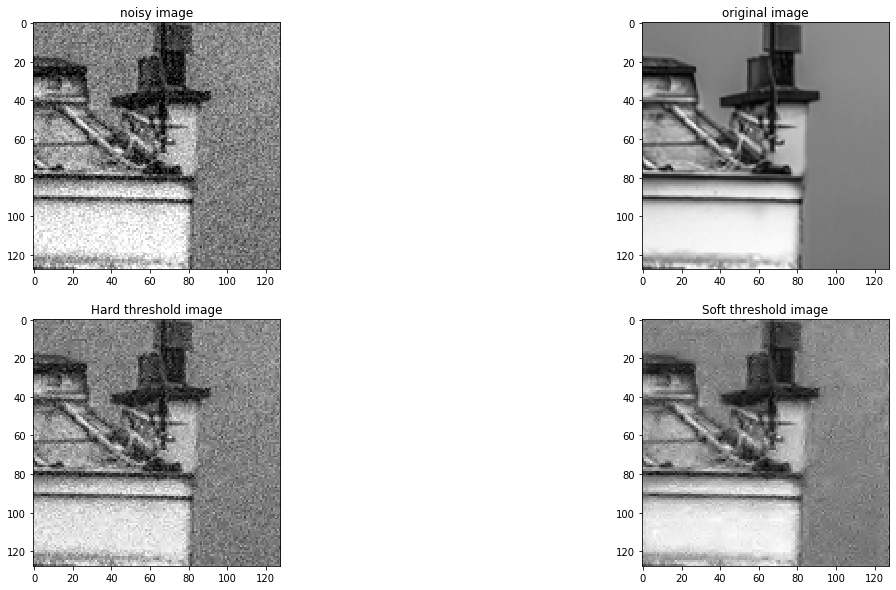

In [17]:
iw1Soft = IWT(w1soft,nwav+1)
iw1hardT = IWT(w1hardT,nwav+1)
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title("noisy image")
plt.imshow(noisy_image)
plt.subplot(2,2,2)
plt.title("original image")
plt.imshow(image)
plt.subplot(2,2,3)
plt.title("Hard threshold image")
plt.imshow(iw1hardT)
plt.subplot(2,2,4)
plt.title("Soft threshold image")
plt.imshow(iw1Soft)
print("hard snr: ",snr(image, iw1hardT),"soft snr: ",snr(image, iw1Soft) )
plt.show()

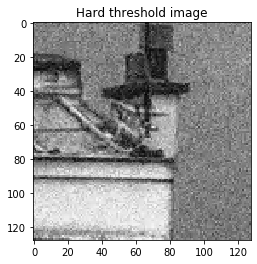

In [22]:
plt.title("Hard threshold image")
plt.imshow(iw1hardT)
plt.show()


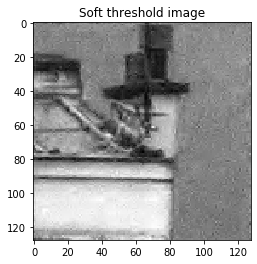

In [23]:
plt.title("Soft threshold image")
plt.imshow(iw1Soft)
plt.show()

### Estimate best threshold for soft and hard threshold

In [18]:
t=0.001
nb_it= 200;
allsnr_hard = [0]*nb_it
allsnr_soft = [0]*nb_it;
for i in range(0,nb_it):
    hardT_n = np.max(w1)*((i+1)*t);
    #print(hardT_n)
    w1soft_n= SoftThreshold(w1,hardT_n)   
    w1hardT_n = Hardthreeshold(w1,hardT_n)
    iw1Soft_n = IWT(w1soft_n,nwav+1)
    iw1hardT_n = IWT(w1hardT_n,nwav+1)
    snr_hard_n = snr(image, iw1hardT_n)
    snr_soft_n = snr(image, iw1Soft_n)
    allsnr_hard[i]= snr_hard_n
    allsnr_soft[i]= snr_soft_n
    
print(allsnr_hard,'\n')
print(allsnr_soft)
print(len(allsnr_soft))

[17.551117534430745, 17.558033577705125, 17.57390098810706, 17.607081219478673, 17.656141085303954, 17.731070832266198, 17.833590394704913, 17.93419835876016, 18.06494553259284, 18.232146266230526, 18.41697642291786, 18.63521646922883, 18.875899093268345, 19.112672040220552, 19.35217047315974, 19.624274023331644, 19.88198353717373, 20.140030303487183, 20.383785392750383, 20.51411050064514, 20.7170383791074, 20.83615800045465, 20.984869933588755, 21.09193785754238, 21.12794925661656, 21.16249694145292, 21.19251006288603, 21.13776788679461, 21.06367936669192, 20.986060791214932, 20.87537932401135, 20.769304252196473, 20.642005027618723, 20.48647298880403, 20.374530634525904, 20.249097507299496, 20.207410334051033, 20.125014940288516, 20.033574662941426, 19.945565646382114, 19.886812185048257, 19.7853372875733, 19.729982670534145, 19.582010385263764, 19.451926545636415, 19.307307749399104, 19.221026773446297, 19.162558813510685, 19.07786184780246, 18.988492357400347, 18.86596760055422, 18

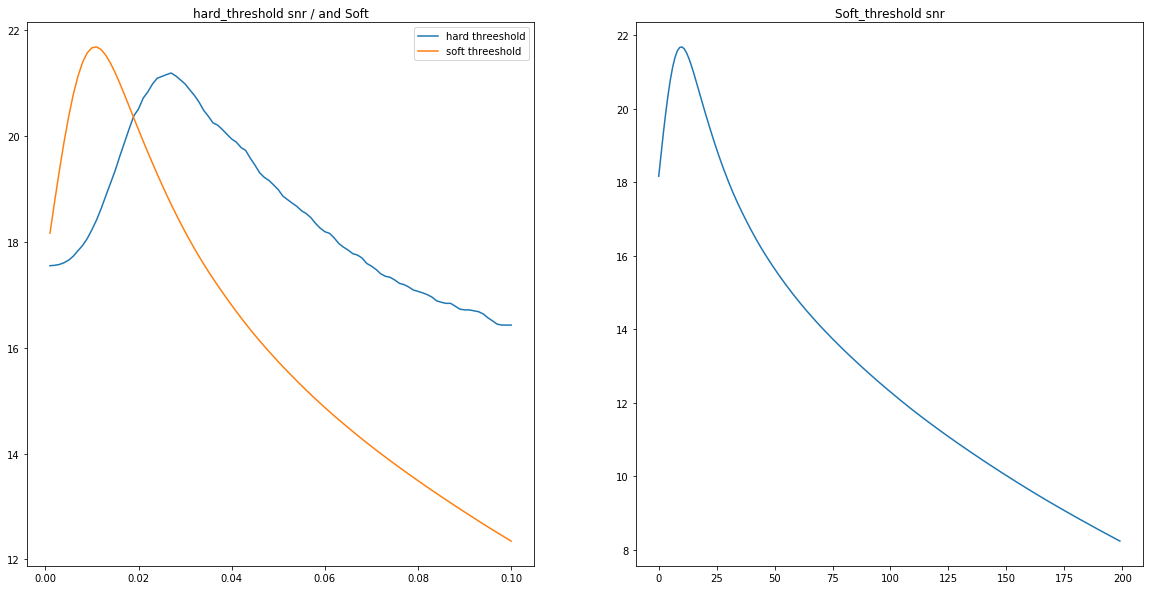

bestThard snr:  21.19251006288603 bestTsoft snr:  21.686229045623037
bestThard it:  [[26]] bestTsoft it:  [[10]]
bestThard snr:  21.19251006288603 bestTsoft snr:  21.686229045623037


In [19]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title("hard_threshold snr / and Soft")
nbaffiche = 100
plt.plot(t*numpy.linspace(1,nbaffiche,nbaffiche),allsnr_hard[0:nbaffiche],label= "hard threeshold")
plt.plot(t*numpy.linspace(1,nbaffiche,nbaffiche),allsnr_soft[0:nbaffiche],label= "soft threeshold")
plt.legend()
plt.subplot(1,2,2)
plt.title("Soft_threshold snr")
plt.plot(allsnr_soft)
plt.show()
bestThard = np.max(allsnr_hard)
bestTsoft = np.max(allsnr_soft)
it_hard = np.argwhere(allsnr_hard==np.max(allsnr_hard))
it_soft = np.argwhere(allsnr_soft==np.max(allsnr_soft))
print("bestThard snr: ",bestThard,"bestTsoft snr: ",bestTsoft)
print("bestThard it: ",it_hard,"bestTsoft it: ",it_soft)
print("bestThard snr: ",allsnr_hard[it_hard[0,0]],"bestTsoft snr: ",allsnr_soft[it_soft[0,0]])

%du max hard:  2.6 %du max Soft:  0.9999999999999999
max w1 =  2056.354122578647
Best hard threeshold for snr:  53.465207187044825 
Best Soft threeshold for snr:  20.56354122578647
hard snr:  21.16249694145292 soft snr:  21.668976100320215


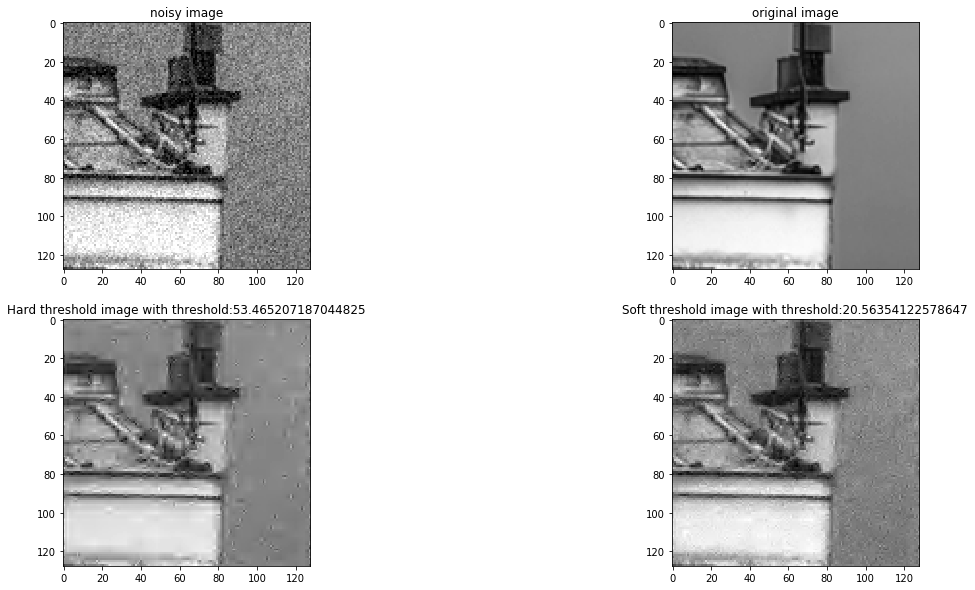

In [28]:
t_hard = np.max(w1)*it_hard[0,0]*t
t_soft = np.max(w1)*it_soft[0,0]*t

print("%du max hard: ",t_hard/ np.max(w1)*100,"%du max Soft: ",t_soft/ np.max(w1)*100)
print("max w1 = ",np.max(w1))
print("Best hard threeshold for snr: ",t_hard,"\nBest Soft threeshold for snr: ",t_soft)
w1soft_best= SoftThreshold(w1,t_soft)   
w1hardT_best = Hardthreeshold(w1,t_hard)

iw1Soft_best = IWT(w1soft_best,nwav+1)
iw1hardT_best = IWT(w1hardT_best,nwav+1)

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title("noisy image")
plt.imshow(noisy_image)
plt.subplot(2,2,2)
plt.title("original image")
plt.imshow(image)
plt.subplot(2,2,3)
plt.title("Hard threshold image with threshold:"+str(t_hard))
plt.imshow(iw1hardT_best)
plt.subplot(2,2,4)
plt.title("Soft threshold image with threshold:"+str(t_soft))
plt.imshow(iw1Soft_best)
print("hard snr: ",snr(image, iw1hardT_best),"soft snr: ",snr(image, iw1Soft_best) )
plt.show()


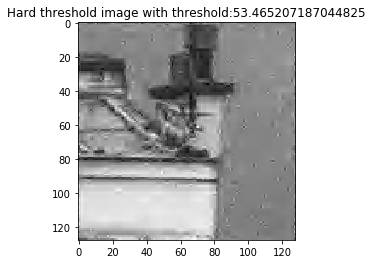

In [24]:
plt.title("Hard threshold image with threshold:"+str(t_hard))
plt.imshow(iw1hardT_best)


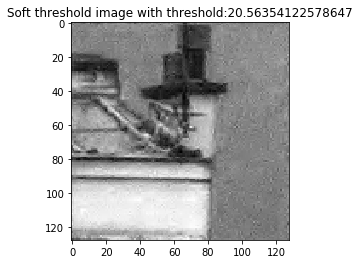

In [25]:
plt.title("Soft threshold image with threshold:"+str(t_soft))
plt.imshow(iw1Soft_best)

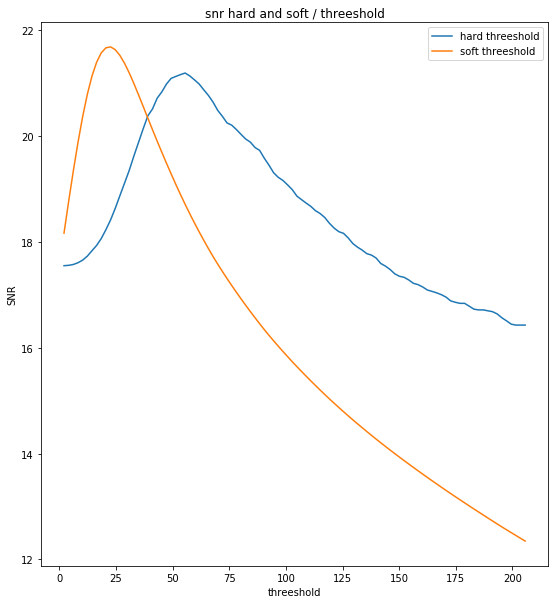

In [26]:
snr_result=[ 17.603420506790165, 17.60348645246212, 17.628698058826394, 18.09902566336656, 19.485562606281714, 20.524547388912815, 20.89116719773836, 20.840756643729662, 20.507749029720177, 19.986709570050067, 19.35965751537526, 18.70772789177049, 18.093437574333482, 17.548155512930382, 17.077708683058127, 16.676387324959762, 16.336519697046693, 16.049464801987522, 15.805454809141121, 15.594835739600352, 15.40939723061947, 15.242965351832154, 15.09131828176534, 14.951759156349231, 14.822620775202108, 14.702849258393996, 14.591713275067661, 14.4886288419255, 14.393068400979153]
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title("snr hard and soft / threeshold")
nbaffiche = 100
plt.plot(np.max(w1)*t*numpy.linspace(1,nbaffiche,nbaffiche),allsnr_hard[0:nbaffiche],label= "hard threeshold")
plt.plot(np.max(w1)*t*numpy.linspace(1,nbaffiche,nbaffiche),allsnr_soft[0:nbaffiche],label= "soft threeshold")
plt.xlabel("threeshold")
plt.ylabel("SNR")
plt.legend()
#plt.subplot(1,2,2)
#plt.title("NL_means Snr/tau")
#plt.plot(snr_result,label= "Snr for NL_means")
#plt.xlabel("tau")
#plt.ylabel("SNR")
#plt.legend()

### Dans la litérature le seuil optimum est 
\begin{equation}S = \sigma\sqrt{2logN}\end{equation}
N nombre de point du signal, dans notre cas le nombre de pixel

In [38]:
optimal_threesh = np.sqrt(sigma) * np.sqrt(2*np.log(image.size))
print("optimal_threesh: ",optimal_threesh)
print(image.size)
print(image.shape[0],image.shape[1])


optimal_threesh:  19.70183801358567
16384
128 128
